<a href="https://colab.research.google.com/github/JericCantos/DisasterTweetPredictions/blob/main/notebooks/DisasterTweetPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project I aim to train and evaluate various models towards the task of classifying whether or not a tweet pertains to a disaster.

We begin by preprocessing the dataset, which involves:
1. Fixing encoding issues
2. Removing punctuation marks, digits, and URLs
3. Removing common english stop words
4. Tokenizing and lemmatizing the words

Given the imbalance between disaster- and non-disaster-tagged tweets, we stratify our train-test split. We also ultimately evaluate the models based on their F1-score.

Hyperparameters for each model and for the TF-IDF Vectorizer are tuned through grid search with crossvalidation.

After training the models on the dataset, common, high-frequency words between disaster- and non-disaster-tagged tweets were identified and removed to see if it will affect model performance.

# Conclusion

## Model Performance

The Multinomial Naive Bayes variant optimized for F1 trained on a dataset with all the words available achieved the best F1 score on the test set. It is followed closely by Logistic Regression optimized for F1 score.

Due to the extremely long runtimes, XGBoost was trained with almost default hyperparameters (only n_estimators had two options), which may contribute to why all XGBoost variants performed worse overall. However, it could also be that the classes are linearly separable, making simpler models perform better.

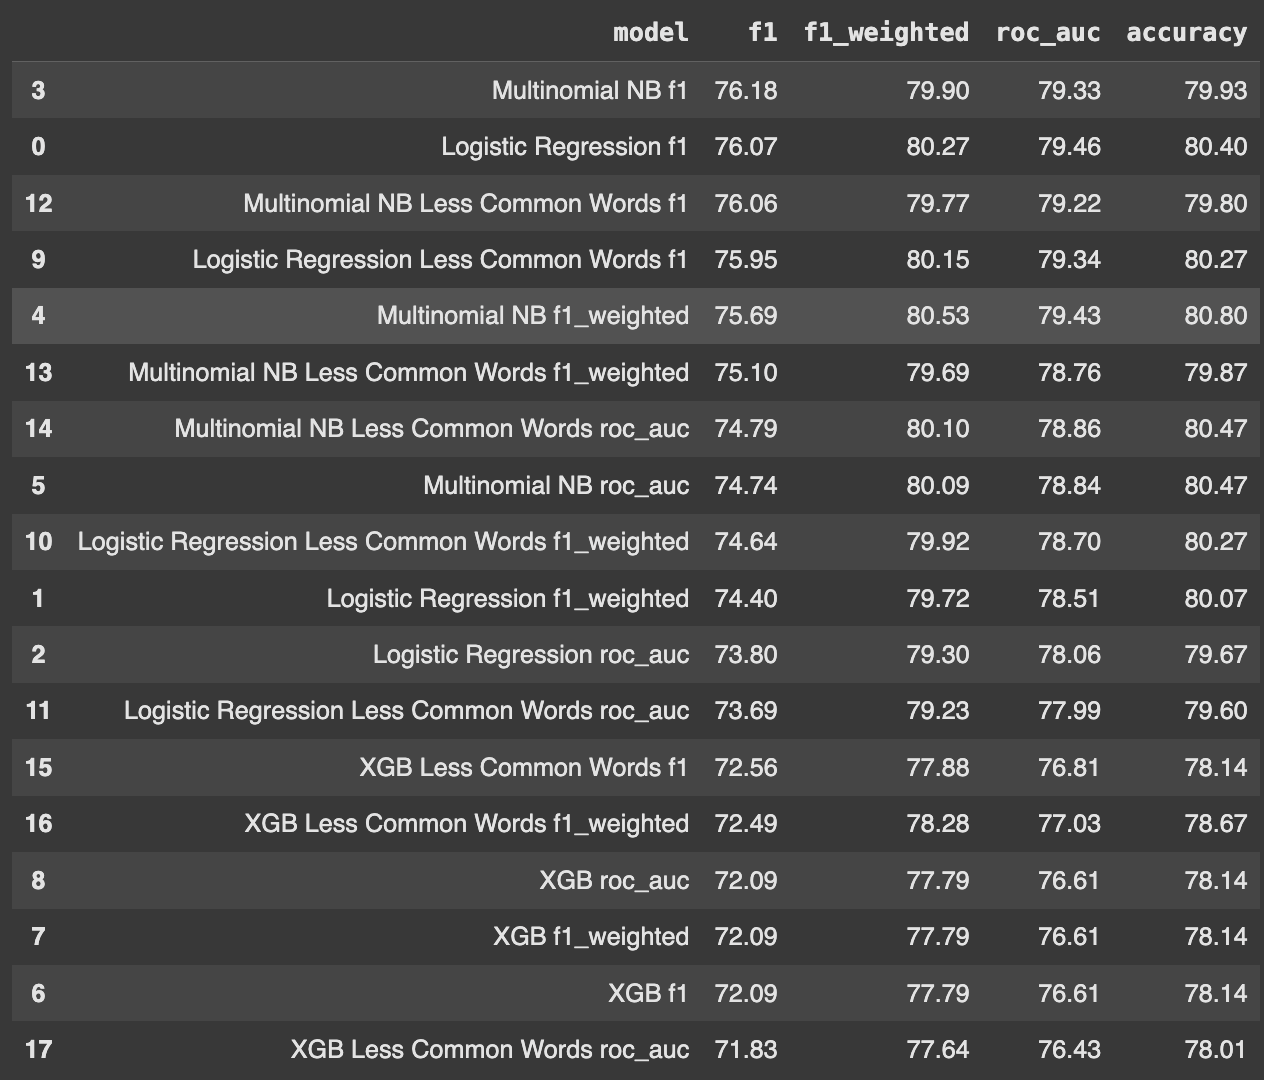

## False Predictions

With a very surface exploration of the false predictions, it is interesting to note that a number of False Negatives seem to be mislabeled (i.e. labeled as a disaster when they are actually not). It would be interesting to see how the classifiers perform if the test dataset was manually corrected to address these false labels.

On the other hand, many false positives carry words that one would associate with disasters, but phrased either as a joke or a theoretical situation, or with tons of hyperbole. Logistic regression was not properly able to infer context or intent in these cases.

A future exploration of the dataset using linear regression where we analyze all tweets very close to the decision boundary (e.g. 0.45 - 0.55 probability) could be fruitful to see if these indeed have a high probability of being mislabeled, and if they should be removed from the dataset for more accurate predictions.

# Setup

## Load Libraries

In [6]:
!pip install ftfy

In [7]:
import requests
import io
from ftfy import fix_text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import nltk
import re
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer # more appropriate for tweets than word_tokenizer
from nltk.corpus import wordnet

# Downloading necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')  # List of common stop words in English
nltk.download('punkt')  # Pre-trained tokenizer models
nltk.download('wordnet')  # WordNet lemmatizer dataset
nltk.download('omw-1.4') # Open Multilingual Wordnet to improve WordNet dataset
nltk.download('averaged_perceptron_tagger')  # Needed for POS tagging
nltk.download('averaged_perceptron_tagger_eng') # Needed for POS tagging

# Libraries for text feature extraction and model training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Libraries for model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


## Load Dataset

In [8]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))
    # Decode as UTF-8 manually, not using response.text
    #decoded_content = response.content.decode('utf-8', errors='replace')
    #return pd.read_csv(io.StringIO(decoded_content))

In [9]:
file_ids = {
    "train": "1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL",
}

# train: https://drive.google.com/file/d/1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL/view?usp=drive_link

In [10]:
df_train = load_csv_from_url(make_drive_url(file_ids["train"]))

In [11]:
df_train.shape

(7613, 2)

In [12]:
df_train = df_train.drop_duplicates()
df_train.shape

(7521, 2)

### Fix Double Encoding Errors

In [13]:
# Fix encoding of all tweets to avoid words like "America\x89Ûªs"
df_train['text'] = df_train['text'].apply(fix_text)

In [14]:
def fix_double_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text


In [15]:
df_train['text'] = df_train['text'].apply(lambda t: fix_double_encoding(fix_text(t)))

In [16]:
def repair_text(s):
    if not isinstance(s, str):
        return s
    try:
        # step 1: encode the visible garbage characters as if they were latin1 bytes
        # step 2: decode them back as UTF-8
        s_fixed = s.encode('cp1252', errors='ignore').decode('utf-8', errors='ignore')
        return s_fixed
    except Exception:
        return s


In [17]:
df_train['text'] = df_train['text'].apply(repair_text)

In [18]:
df_train.head(20)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


# Data Preprocessing

In [19]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [20]:
def fix_encoding(text):
    try:
        # Encode as latin1 and decode as utf-8 to reverse mojibake
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        # If it fails, return original
        return text

In [21]:
# Define the preprocessing function
def preprocess_text(sentences):
    # Fix encoding of all tweets to avoid words like "America\x89Ûªs"
    sentences = [fix_encoding(sentence) for sentence in sentences]

    # Convert all tokens to lowercase
    sentences = [sentence.lower() for sentence in sentences]

    # Replace Unicode full-width @ with normal @
    sentences = [re.sub(r"＠", "@", sentence) for sentence in sentences]


    # Remove punctuation using regex
    # Keep hashtags and mentions
    sentences = [re.sub(r"[^\w\s'#@]", "", sentence) for sentence in sentences]

    # Remove numbers and URLs starting with http or www
    sentences = [re.sub(r"http\S+|www\S+|\d+", "", sentence)
                  for sentence in sentences]


    # Remove extra whitespace between words
    sentences = [" ".join(sentence.split()) for sentence in sentences]

    # Tokenize sentences into words
    tokenizer = TweetTokenizer(preserve_case=False)
    sentences = [tokenizer.tokenize(sentence) for sentence in sentences]

    # Remove stop words and single-letter wordsd
    stop_words = set(stopwords.words('english'))  # Load English stop words
    filtered_sentences = []
    for sentence in sentences:
        filtered_sentence = [word for word in sentence if
                             word not in stop_words and
                             len(word) > 1]
        filtered_sentences.append(filtered_sentence)


    lemmatized_sentences = []
    lemmatizer = WordNetLemmatizer()
    for sentence in filtered_sentences:
      # Get POS tags for each word
      pos_tags = nltk.pos_tag(sentence)

      # Lemmatize with POS tags
      lemmas = []
      for word, tag in pos_tags:
        wn_pos = get_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(word, pos=wn_pos))
      lemmatized_sentences.append(lemmas)

    return [' '.join(sentence) for sentence in lemmatized_sentences]

In [22]:
df_train['cleaned_tweets'] = preprocess_text(df_train['text'])

In [23]:
df_train['cleaned_tweets'].head(20)

,cleaned_tweets
0,deed reason #earthquake may allah forgive u
1,forest fire near la ronge sask canada
2,resident ask shelter place notify officer evac...
3,people receive #wildfires evacuation order cal...
4,get sent photo ruby #alaska smoke #wildfires p...
5,#rockyfire update california hwy close directi...
6,#flood #disaster heavy rain cause flash flood ...
7,top hill see fire wood
8,there's emergency evacuation happen building a...
9,afraid tornado come area


In [24]:
df_train['cleaned_tweets']

,cleaned_tweets
0,deed reason #earthquake may allah forgive u
1,forest fire near la ronge sask canada
2,resident ask shelter place notify officer evac...
3,people receive #wildfires evacuation order cal...
4,get sent photo ruby #alaska smoke #wildfires p...
...,...
7604,#worldnews fall powerlines glink tram update f...
7605,flip side walmart bomb everyone evacuate stay ...
7606,suicide bomber kill saudi security site mosque...
7608,two giant crane hold bridge collapse nearby home


# Train-Test Split

In [25]:
df = pd.DataFrame({'text': df_train['cleaned_tweets'],
                   'target': df_train['target']})
df.head()

,text,target
0,deed reason #earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive #wildfires evacuation order cal...,1
4,get sent photo ruby #alaska smoke #wildfires p...,1


In [26]:
df['target'].value_counts(normalize=True)

,proportion
target,
0,0.573727
1,0.426273


There is a slight imbalance in the dataset (~57% negative, ~43% positive). Stratification is a good idea.

In [27]:
# Use train_test_split instead so we can stratify the split to maintain balance
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['target'],
                                                    test_size=0.2,
                                                    stratify=df['target'],
                                                    random_state=42)

# Print sizes of training and test sets
print("Size of training set:", len(X_train))
print("Size of test set:", len(X_test))

Size of training set: 6016
Size of test set: 1505


# Feature Extraction

In [28]:
# Use a tweet tokenizer in the TfidVectorizer so it becomes
# aware of mentions and hashtags
tweet_tokenizer = TweetTokenizer(preserve_case=False)

tfidf_vectorizer = TfidfVectorizer(
    tokenizer = tweet_tokenizer.tokenize,
    preprocessor = None,
    token_pattern = None
)

# Transform the training data into a TF-IDF matrix
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data into a TF-IDF matrix
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Check the number of samples and features
num_samples, num_features = X_train_tfidf.shape
print("Train #Samples: {}, #Features: {}".format(num_samples, num_features))
num_samples_test, num_features_test = X_test_tfidf.shape
print("Test #Samples: {}, #Features: {}".format(num_samples_test,
                                                num_features_test))

Train #Samples: 6016, #Features: 13638
Test #Samples: 1505, #Features: 13638


In [29]:
tfidf_vectorizer.get_feature_names_out()

array(['##book', '##fukushima', '##youtube', ..., 'zrnf', 'zurich',
       'zzzz'], dtype=object)

# Machine Learning Setup

Given the imbalance in the dataset, I would choose F1 score as the ultimate metric for evaluation. However, I will train versions of various models optimizing for f1, f1-weighted, and roc-auc to see which one will give the best F1 score.

## Global Configuration Values

In [30]:
# Dictionary of Results
model_comparisons = {}

scoring_functions = ['f1', 'f1_weighted', 'roc_auc']

## Helper Functions

In [31]:
def create_pipeline(model):
  return Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer = tweet_tokenizer.tokenize,
        preprocessor = None,
        token_pattern = None
    )),
    ('model', model)
  ])

In [32]:
def get_param_grid(model):
    # Return an appropriate parameter grid for GridSearchCV,
    # based on the model type.

    # Shared TF-IDF hyperparameters
    base_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
        'tfidf__max_df': [0.8, 1.0], # ignore too common words
        'tfidf__min_df': [1, 2], # ignore too rare words
    }

    # Model-specific hyperparameters
    if isinstance(model, XGBClassifier):
        model_grid = {
            'model__n_estimators': [100, 500],
            #'model__max_depth': [5, 10],
            #'model__learning_rate': [0.05, 0.1],
            #'model__subsample': [0.7, 1.0],
            #'model__colsample_bytree': [0.7, 1.0],
        }

    elif isinstance(model, LogisticRegression):
        model_grid = {
            'model__C': [0.1, 1, 10],
            'model__solver': ['saga'],
            #'model__penalty': ['l2', 'l1'],  # saga supports both
            'model__max_iter': [100, 200]
        }

    elif isinstance(model, MultinomialNB):
        model_grid = {
            'model__alpha': [0.1, 0.5, 1.0],
            'model__fit_prior': [True, False]
        }

    else:
        raise ValueError(f"Model type {type(model).__name__} not supported.")

    # Merge shared TF-IDF + model-specific parameters
    full_grid = {**base_grid, **model_grid}

    return full_grid

In [33]:
def train_model(pipeline, X_train_scaled, y_train,
                X_test_scaled, y_test,
                param_grid, ispca, n_components, scoring, cv=5,
                              numeric_features=  ['applicant_income',
                                          'coapplicant_income',
                                          'loan_amount' ]):

  if(ispca):
    print ('Components:', i)
    pca = PCA(n_components=n_components,
                         random_state=42)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)

  # Set up the GridSearchCV
  grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv,
                            scoring=scoring, n_jobs=-1, verbose=1)

  # Fit the grid search model
  grid_search.fit(X_train_scaled, y_train)

  # Best parameters found by Grid Search
  print("Best Hyperparameters:", grid_search.best_params_)

  return (grid_search.best_estimator_,
          X_train_scaled,
          X_test_scaled,
          y_train,
          y_test,
          grid_search.best_params_,
          )

In [34]:
def evaluate_model (model, X_train, y_train, X_test, y_test, best_params,
                    run_label):
  print(f'-----{run_label}-----')

  train_pred = model.predict(X_train)
  y_pred = model.predict(X_test)

  # evaluate train
  train_accuracy = round(accuracy_score(y_train, train_pred)*100, 2)
  train_conf_matrix = confusion_matrix(y_train, train_pred)
  train_class_report = classification_report(y_train, train_pred)
  train_roc_auc = round(roc_auc_score(y_train, train_pred)*100, 2)
  train_f1 = round(f1_score(y_train, train_pred)*100, 2)
  train_f1_weighted = round(f1_score(y_train, train_pred, average='weighted')*100, 2)

  # evaluate test
  accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)
  roc_auc = round(roc_auc_score(y_test, y_pred)*100, 2)
  f1 = round(f1_score(y_test, y_pred)*100, 2)
  f1_weighted = round(f1_score(y_test, y_pred, average='weighted')*100, 2)

  # Printing evaluation metrics
  print("Training Confusion Matrix:\n", train_conf_matrix)
  print("Testing Confusion Matrix:\n", conf_matrix)
  print("Accuracy: Test", accuracy, ' - ' , train_accuracy, 'Train')
  print("ROC AUC: Test", roc_auc, ' - ' , train_roc_auc, 'Train')
  print("F1-score: Test", f1, ' - ' , train_f1, 'Train')
  print("Weighted F1-score:", f1_weighted, ' - ' , train_f1_weighted, 'Train')

  print("Training Classification Report:\n", train_class_report)
  print("Test Classification Report:\n", class_report)

  #Save the run stats
  model_comparisons[run_label] = {'accuracy': accuracy,
                                  'conf_matrix': conf_matrix,
                                  'class_report': class_report,
                                  'roc_auc' : roc_auc,
                                  'f1' : f1,
                                  'f1_weighted': f1_weighted,
                                  'best_params': best_params,
                                  'model': model}


In [35]:
def model_summaries (model_list=None):
  df_models = pd.DataFrame.from_dict(model_comparisons, orient='index')
  df_models = df_models[['f1', 'f1_weighted', 'roc_auc', 'accuracy' ]]
  df_models = df_models.reset_index()
  df_models.rename(columns={'index': 'model'}, inplace=True)

  if model_list is None:
    return df_models.sort_values(by='f1', ascending=False)

  return df_models[df_models['model'].isin(model_list)]\
              .sort_values(by='f1', ascending=False)

In [36]:
def get_false_predictions(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_true = y_test

  results = pd.DataFrame({
    'text': X_test,
    'true_label': y_true,
    'predicted_label': y_pred
  })

  false_positives = (results[(results.true_label == 0)
                    & (results.predicted_label == 1)])
  false_negatives = (results[(results.true_label == 1)
                    & (results.predicted_label == 0)])

  return false_positives, false_negatives



# Logistic Regression

Logistic regression
optimized for F1 Score with the following hyperparameters resulted in the best F1 Score among the tested variants:

```
Best Hyperparameters: {
  'model__C': 10,
  'model__max_iter': 100,
  'model__solver': 'saga',
  'tfidf__max_df': 0.8,
  'tfidf__min_df': 1,
  'tfidf__ngram_range': (1, 2)
}
```

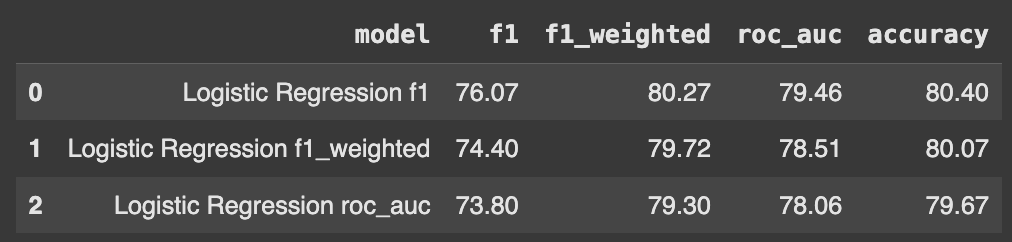

In [32]:
'''
Scoring Function: f1
Best Hyperparameters: {
  'model__C': 10,
  'model__max_iter': 100,
  'model__solver': 'saga',
  'tfidf__max_df': 0.8,
  'tfidf__min_df': 1,
  'tfidf__ngram_range': (1, 2)
}
'''

for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = LogisticRegression(max_iter=10000, random_state=42,)

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Logistic Regression {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__C': 10, 'model__max_iter': 100, 'model__solver': 'saga', 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
-----Logistic Regression f1-----
Training Confusion Matrix:
 [[3427   25]
 [  58 2506]]
Testing Confusion Matrix:
 [[741 122]
 [173 469]]
Accuracy: Test 80.4  -  98.62 Train
ROC AUC: Test 79.46  -  98.51 Train
F1-score: Test 76.07  -  98.37 Train
Weighted F1-score: 80.27  -  98.62 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3452
           1       0.99      0.98      0.98      2564

    accuracy                           0.99      6016
   macro avg       0.99      0.99      0.99      6016
weighted avg       0.99      0.99      0.99      6016

Test Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83   

In [33]:
df_summary = model_summaries(['Logistic Regression f1',
                   'Logistic Regression f1_weighted',
                   'Logistic Regression roc_auc'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
0,Logistic Regression f1,76.07,80.27,79.46,80.40
1,Logistic Regression f1_weighted,74.40,79.72,78.51,80.07
2,Logistic Regression roc_auc,73.80,79.30,78.06,79.67


# Multinomial Naive Bayes

Optimizing for F1 score with Multinomial Naive Bayes also yields the best F1 score on the test dataset among all variants at 76.18.  The best Logistic Regression model came in just slightly under.

```
Best Hyperparameters: {
  'model__alpha': 1.0,
  'model__fit_prior': False,
  'tfidf__max_df': 0.8,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': (1, 1)
}
```

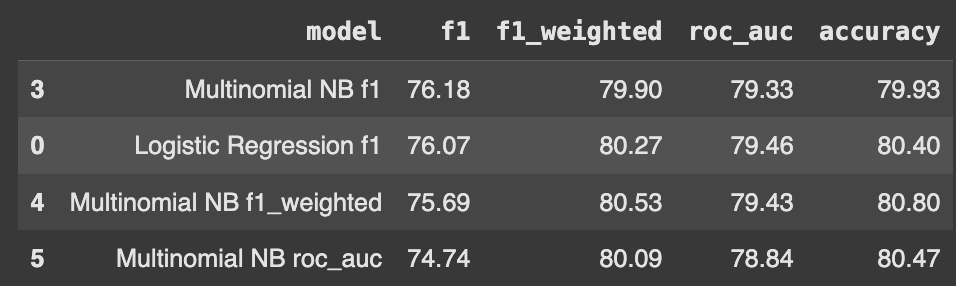

In [34]:
'''
Scoring Function: f1
Best Hyperparameters: {
  'model__alpha': 1.0,
  'model__fit_prior': False,
  'tfidf__max_df': 0.8,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': (1, 1)
}
'''

for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = MultinomialNB()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Multinomial NB {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__alpha': 1.0, 'model__fit_prior': False, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----Multinomial NB f1-----
Training Confusion Matrix:
 [[3123  329]
 [ 477 2087]]
Testing Confusion Matrix:
 [[720 143]
 [159 483]]
Accuracy: Test 79.93  -  86.6 Train
ROC AUC: Test 79.33  -  85.93 Train
F1-score: Test 76.18  -  83.82 Train
Weighted F1-score: 79.9  -  86.54 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      3452
           1       0.86      0.81      0.84      2564

    accuracy                           0.87      6016
   macro avg       0.87      0.86      0.86      6016
weighted avg       0.87      0.87      0.87      6016

Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       863
           1   

In [40]:
df_summary = model_summaries(['Multinomial NB f1',
                   'Multinomial NB f1_weighted',
                   'Multinomial NB roc_auc',
                   'Logistic Regression f1'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
3,Multinomial NB f1,76.18,79.90,79.33,79.93
0,Logistic Regression f1,76.07,80.27,79.46,80.40
4,Multinomial NB f1_weighted,75.69,80.53,79.43,80.80
5,Multinomial NB roc_auc,74.74,80.09,78.84,80.47


# XGBoost Classifier

The XGBoost grid search takes so much time that I was only able to tune the number of estimators alongside the TF-IDF parameters. All XGBoost variants performed worse than Multinomial Naive Bayes and Logistic Regression.

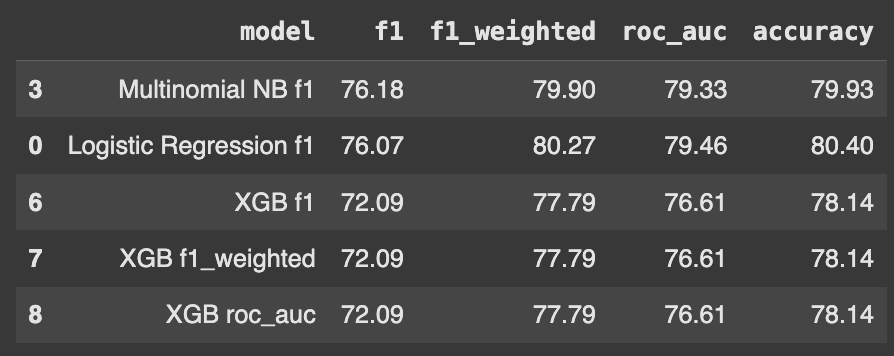

In [36]:
for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = XGBClassifier()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'XGB {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'model__n_estimators': 500, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 4)}
-----XGB f1-----
Training Confusion Matrix:
 [[3395   57]
 [ 322 2242]]
Testing Confusion Matrix:
 [[751 112]
 [217 425]]
Accuracy: Test 78.14  -  93.7 Train
ROC AUC: Test 76.61  -  92.9 Train
F1-score: Test 72.09  -  92.21 Train
Weighted F1-score: 77.79  -  93.64 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      3452
           1       0.98      0.87      0.92      2564

    accuracy                           0.94      6016
   macro avg       0.94      0.93      0.93      6016
weighted avg       0.94      0.94      0.94      6016

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       863
           1       0.79      0.66      0.72   

In [41]:
df_summary = model_summaries(['XGB f1',
                   'XGB f1_weighted',
                   'XGB roc_auc',
                   'Multinomial NB f1',
                   'Logistic Regression f1'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
3,Multinomial NB f1,76.18,79.90,79.33,79.93
0,Logistic Regression f1,76.07,80.27,79.46,80.40
6,XGB f1,72.09,77.79,76.61,78.14
7,XGB f1_weighted,72.09,77.79,76.61,78.14
8,XGB roc_auc,72.09,77.79,76.61,78.14


# False Predictions Exploration

As the performance of Logistic Regression and Multinomial Naive Bayes seem comparable, let's just do a quick exploration of the false predictions done by the best Logistic Regression model.

In [44]:
model = model_comparisons['Logistic Regression f1']['model']
false_positives, false_negatives = get_false_predictions(model, X_test, y_test)
print (f'False Positives: {len(false_positives)}')
print (f'False Negatives: {len(false_negatives)}')

False Positives: 122
False Negatives: 173


## False Positives

There are some examples of tweets being tagged as "disaster-related" which were actually talking about fantasies(movies/shows, songs, books), possibilities, sports, or jokes, but using words that humans may associate with disasters, e.g.:
- 'i never understood guys who wanted to run into burning buildings.'
  - 'you chase murderers.'
    - 'not if they're on fire.'
- || So.... I just watched the trailed for The Dust Storm and I think part of me just died.... Colin is so perfect my goodness.
- Currently Blasting #Benediction - #SanelessTheory -on Metal Devastation Radio-  http://t.co/siGeeQ42cZ

Some talk about things adjacent to disasters (e.g. disaster response/preparedness):
- #hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best
- #stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident tee_
- Do you have a plan in case of a pool chemical emergency? Learn more here: http://t.co/UePPjwvLcb #watersafety @CDC

The model also seems to fall prey to hyperbole:
- Video Captures Man Removing American Flag From Long Beach CA Home Burning It; Arsonist Sought http://t.co/JP2QlrunjJ http://t.co/jbpgkGOwSi
- @CNN the End of Times are upon us. Famine War Death Plague. The presence is growing stronger.

In [45]:
for i, tweet in df_train.loc[false_positives.index, 'text'].head(20).items():
    print(f"{i}: {tweet}\n")

6032: On Thursday at 00:25 we updated our #kml of 2D and 3D #seismic exploration vessels. #offshore #oil http://t.co/btdjGWeKqx

2874: @KarinaGarciaxo_ me & you both & I'll be dam if I get any of that drought bud

6251: New #photo Oak in a snowstorm http://t.co/JhSCGDA2G8 on the #SouthDowns #Hampshire #Winter #photography #art #tree #treescape #treeporn

425: Video Captures Man Removing American Flag From Long Beach CA Home Burning It; Arsonist Sought http://t.co/JP2QlrunjJ http://t.co/jbpgkGOwSi

341: 9 Charts Prove Financial Crisis Part 2 Has BEGUN!: The Financial Armageddon Economic Collapse Blog tracks tren... http://t.co/vHCXTvCINr

2102: RSS: Judge orders Texas to recognize spouse on same-sex death certificate  http://t.co/TZIolfTe5i

1362: 'i never understood guys who wanted to run into burning buildings.'
'you chase murderers.'
'not if they're on fire.'

2780: Currently Blasting #Benediction - #SanelessTheory -on Metal Devastation Radio-  http://t.co/siGeeQ42cZ

5047: she's a n

## False Negatives

Many items seem to have been mislabeled from the start i.e. labeled as a disaster, which our classifier predicts as not. In fact, in these 20 random tweets, it is easier to list the real "mistakes" than the mislabeled tweets.

--- Disaster tweets predicted as non-disaster ---
- In Kalmikya Astrakhan Volgagrad and Dagestan there is already no food left for the locusts http://t.co/79Fw9zWxtP via @TIMEWorld
- Flood-zone : General Raheel Sharif visits Chitral: He  also lauded the efforts of  FWO army troops and army aviation in rescue opera...

The rest of the tweets are not disasters but are labeled as such.


In [46]:
for i, tweet in df_train.loc[false_negatives.index, 'text'].head(20).items():
    print(f"{i}: {tweet}\n")

6291: Doves - The Storm + Greatest Denier (Electric Proms Pt4) http://t.co/xjTpV4OydL

7365: Texas Seeks Comment on Rules for Changes to WindstormInsurer http://t.co/92fwtObi3U

1663: Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/87eFCBIczM

1969: Now on #ComDev #Asia: Radio stations in #Bangladesh broadcasting #programs ?to address the upcoming cyclone #komen http://t.co/iOVr4yMLKp

2748: In Kalmikya Astrakhan Volgagrad and Dagestan there is already no food left for the locusts

  http://t.co/79Fw9zWxtP via @TIMEWorld

2491: Unexercised honda run-down neighborhood desolate: PSqD

1531: Russian nuclear-biological-chemical (NBC) brigade 'emergency response' exercise in Southern MD http://t.co/Ul5XdblmBk http://t.co/VjHpVLnbaw

5223: @tiggr_ why only Squad Obliteration?

6476: @SaintRobinho86 someone has to be at the bottom of every league. Tonight clearly demonstrated why the Lions are where they are - sunk!

5666: 

# Model Tweaking

In [41]:
disaster_tweets = X_train[y_train == 1]
non_disaster_tweets = X_train[y_train == 0]

disaster_tweets.values

array(["@lovemywife @foxnews like shedid public fact journalist bush's washard stop terrorist",
       'watch airport get swallow sandstorm minute',
       'another fake hate crime lesbians burn house else new', ...,
       'pretty neat website get late drought condition area',
       'rly tragedy mp live recount horror #topstories #india timesofindia',
       '#world fedex longer transport bioterror germ wake anthrax lab mishap'],
      dtype=object)

In [42]:
def flatten_tweets(tweets):
  return [word for tweet in tweets for word in tweet.split()]

In [43]:
disaster_tokens = flatten_tweets(disaster_tweets)
non_disaster_tokens = flatten_tweets(non_disaster_tweets)

In [44]:
disaster_word_counts = Counter(disaster_tokens)
non_disaster_word_counts = Counter(non_disaster_tokens)

In [45]:
disaster_top_words = disaster_word_counts.most_common(15)
non_disaster_top_words = non_disaster_word_counts.most_common(15)

In [46]:
disaster_df = pd.DataFrame(disaster_top_words, columns = ['Word','Count'])
disaster_df.head()

,Word,Count
0,fire,221
1,bomb,111
2,kill,109
3,get,99
4,via,98


In [47]:
non_disaster_df = pd.DataFrame(non_disaster_top_words, columns = ['Word','Count'])
non_disaster_df.head()

,Word,Count
0,get,241
1,like,237
2,go,149
3,new,123
4,make,110


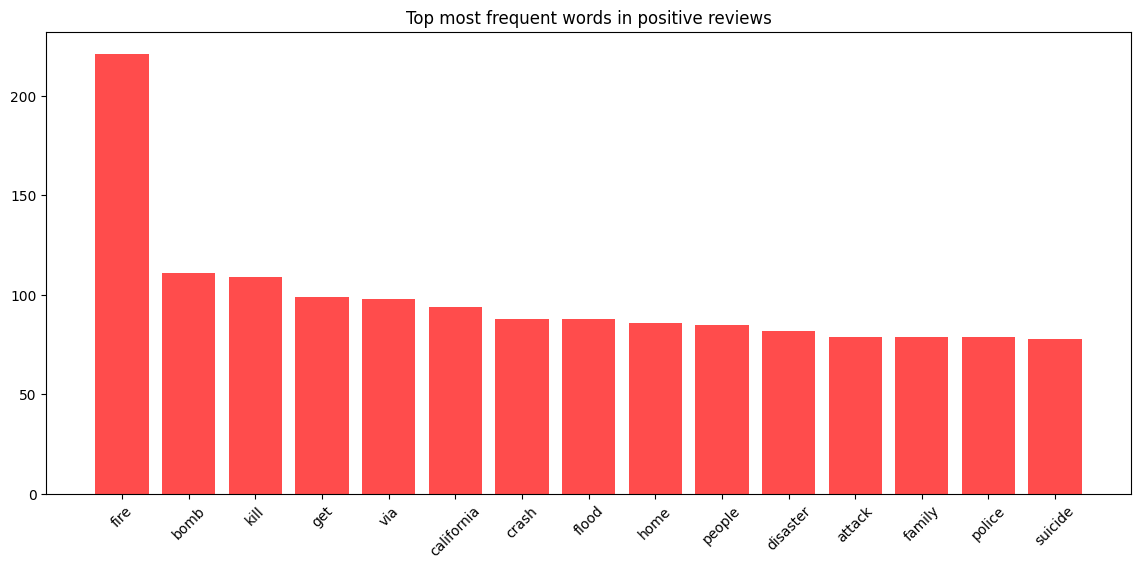

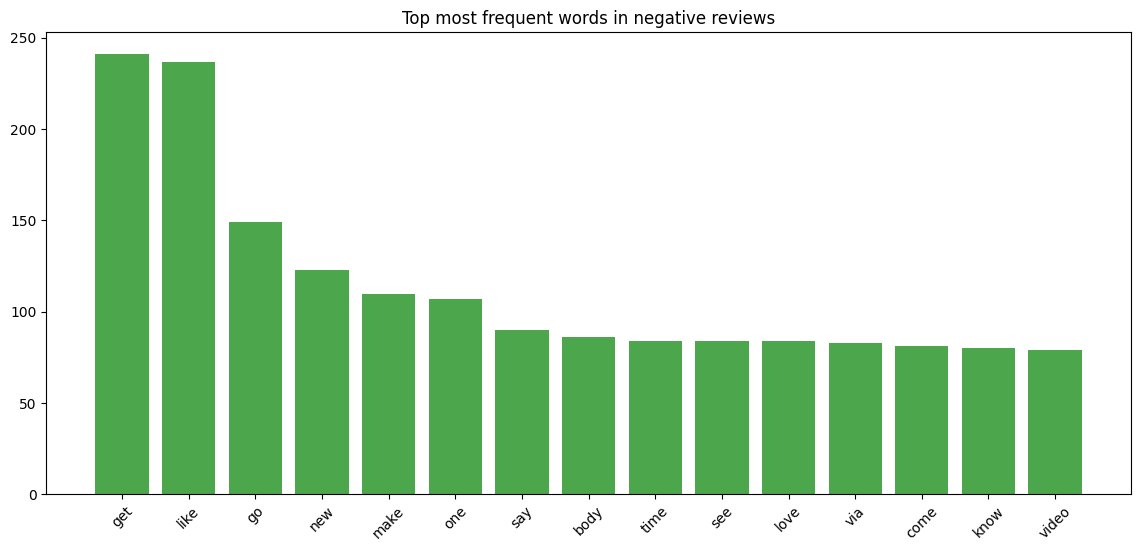

In [48]:
plt.figure(figsize = (14, 6))
plt.bar(disaster_df['Word'], disaster_df['Count'], color='red', alpha=0.7)
plt.title('Top most frequent words in positive reviews')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize = (14, 6))
plt.bar(non_disaster_df['Word'], non_disaster_df['Count'], color='green', alpha=0.7)
plt.title('Top most frequent words in negative reviews')
plt.xticks(rotation=45)
plt.show()

In [49]:
df_common = non_disaster_df[non_disaster_df['Word'].isin(disaster_df['Word'])]
df_common

,Word,Count
0,get,241
11,via,83


Remove `get` and `via` from the train and test datasets and then run the models again to see if it results in better predictions.

In [50]:
common_words = df_common['Word'].values
common_words

array(['get', 'via'], dtype=object)

In [51]:
# create a regex pattern that can isolate the common words for removal
pattern = r'\b(' + '|'.join(common_words) + r')\b'

X_train_reduced = X_train.str.replace(pattern, '', regex=True, case=False)
X_test_reduced  = X_test.str.replace(pattern, '', regex=True, case=False)


In [52]:
X_train_reduced

,text
6654,@lovemywife @foxnews like shedid public fact j...
5905,watch airport swallow sandstorm minute
384,another fake hate crime lesbians burn house el...
4830,attempted mass murder bring obama administration
2229,wrinkled face deluge decay
...,...
2870,pretty neat website late drought condition area
6776,rly tragedy mp live recount horror #topstories...
587,#world fedex longer transport bioterror germ w...
3649,uber reduces drink drive fatality say independ...


In [53]:
X_test_reduced

,text
6032,thursday update #kml #seismic exploration vess...
6291,dove storm great denier electric prom pt
1158,japan mark th anniversary hiroshima atomic bom...
1026,body bag show pm tremont music hall charlotte ...
7070,tt kettlebell upheaval blueprint chris lopez h...
...,...
2642,temptation always lead destruction
5272,refugio oil spill may costlier big project #news
5166,time obliterate sin
828,new expansion idea bard class holy trinity


## Logistic Regression

Only the variant of logistic regression without the common words that was optimized for weighted f1 score beat its counterpart in terms of performance.

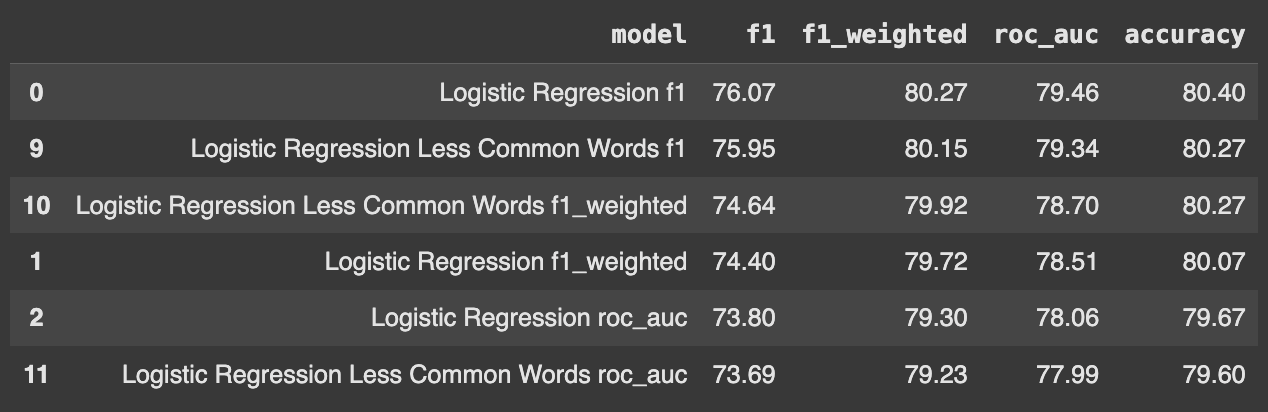

In [54]:
for scoring in scoring_functions:
  my_X_train = X_train_reduced
  my_X_test = X_test_reduced
  my_y_train = y_train
  my_y_test = y_test

  model = LogisticRegression(max_iter=10000, random_state=42,)

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Logistic Regression Less Common Words {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__C': 10, 'model__max_iter': 100, 'model__solver': 'saga', 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
-----Logistic Regression Less Common Words f1-----
Training Confusion Matrix:
 [[3428   24]
 [  58 2506]]
Testing Confusion Matrix:
 [[739 124]
 [173 469]]
Accuracy: Test 80.27  -  98.64 Train
ROC AUC: Test 79.34  -  98.52 Train
F1-score: Test 75.95  -  98.39 Train
Weighted F1-score: 80.15  -  98.64 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3452
           1       0.99      0.98      0.98      2564

    accuracy                           0.99      6016
   macro avg       0.99      0.99      0.99      6016
weighted avg       0.99      0.99      0.99      6016

Test Classification Report:
               precision    recall  f1-score   support

           0       0.81    

In [47]:
df_summary = model_summaries(['Logistic Regression Less Common Words f1',
                   'Logistic Regression Less Common Words f1_weighted',
                   'Logistic Regression Less Common Words roc_auc',
                   'Logistic Regression f1',
                   'Logistic Regression f1_weighted',
                   'Logistic Regression roc_auc'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
0,Logistic Regression f1,76.07,80.27,79.46,80.40
9,Logistic Regression Less Common Words f1,75.95,80.15,79.34,80.27
10,Logistic Regression Less Common Words f1_weighted,74.64,79.92,78.70,80.27
1,Logistic Regression f1_weighted,74.40,79.72,78.51,80.07
2,Logistic Regression roc_auc,73.80,79.30,78.06,79.67
11,Logistic Regression Less Common Words roc_auc,73.69,79.23,77.99,79.60


## Multinomial Naive Bayes

For Multinomial Naive Bayes, only the variant optimized for roc_auc with the common words removed beat its counterpart.

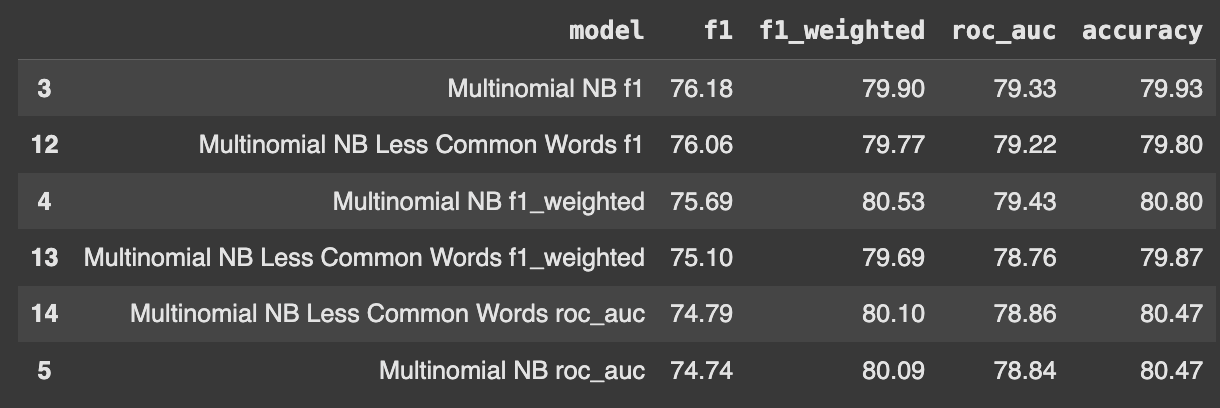

In [56]:
for scoring in scoring_functions:
  my_X_train = X_train_reduced
  my_X_test = X_test_reduced
  my_y_train = y_train
  my_y_test = y_test

  model = MultinomialNB()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Multinomial NB Less Common Words {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__alpha': 1.0, 'model__fit_prior': False, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----Multinomial NB Less Common Words f1-----
Training Confusion Matrix:
 [[3123  329]
 [ 475 2089]]
Testing Confusion Matrix:
 [[718 145]
 [159 483]]
Accuracy: Test 79.8  -  86.64 Train
ROC AUC: Test 79.22  -  85.97 Train
F1-score: Test 76.06  -  83.86 Train
Weighted F1-score: 79.77  -  86.58 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      3452
           1       0.86      0.81      0.84      2564

    accuracy                           0.87      6016
   macro avg       0.87      0.86      0.86      6016
weighted avg       0.87      0.87      0.87      6016

Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       

In [48]:
df_summary = model_summaries(['Multinomial NB Less Common Words f1',
                   'Multinomial NB Less Common Words f1_weighted',
                   'Multinomial NB Less Common Words roc_auc',
                   'Multinomial NB f1',
                   'Multinomial NB f1_weighted',
                   'Multinomial NB roc_auc',
                   'Logistic Regression f1]'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
3,Multinomial NB f1,76.18,79.90,79.33,79.93
12,Multinomial NB Less Common Words f1,76.06,79.77,79.22,79.80
4,Multinomial NB f1_weighted,75.69,80.53,79.43,80.80
13,Multinomial NB Less Common Words f1_weighted,75.10,79.69,78.76,79.87
14,Multinomial NB Less Common Words roc_auc,74.79,80.10,78.86,80.47
5,Multinomial NB roc_auc,74.74,80.09,78.84,80.47


## XGBoost Classifier

After removing the common words, XGBoost optimized for f1 and f1-weighted jumped to the top, but they are still at the bottom of the stack behind the Multinomial NB and Logistic Regression Models.

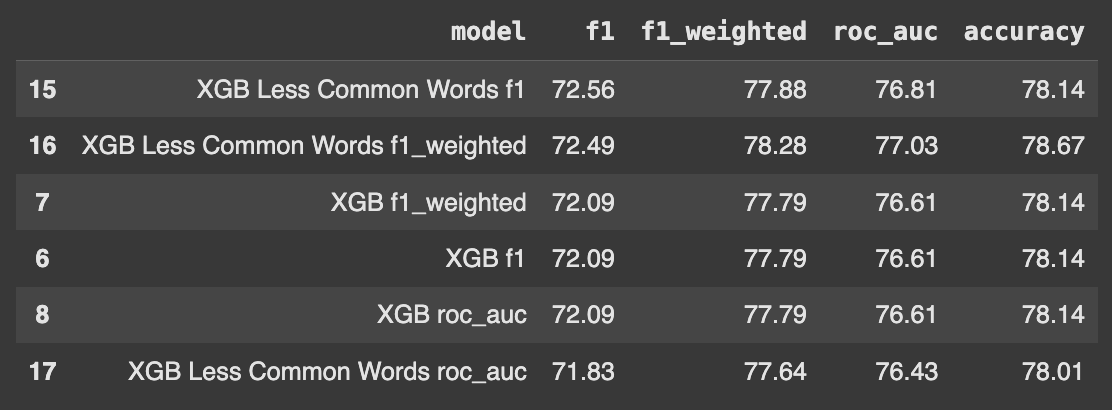

In [58]:
for scoring in scoring_functions:
  my_X_train = X_train_reduced
  my_X_test = X_test_reduced
  my_y_train = y_train
  my_y_test = y_test

  model = XGBClassifier()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'XGB Less Common Words {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'model__n_estimators': 500, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----XGB Less Common Words f1-----
Training Confusion Matrix:
 [[3401   51]
 [ 322 2242]]
Testing Confusion Matrix:
 [[741 122]
 [207 435]]
Accuracy: Test 78.14  -  93.8 Train
ROC AUC: Test 76.81  -  92.98 Train
F1-score: Test 72.56  -  92.32 Train
Weighted F1-score: 77.88  -  93.74 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      3452
           1       0.98      0.87      0.92      2564

    accuracy                           0.94      6016
   macro avg       0.95      0.93      0.94      6016
weighted avg       0.94      0.94      0.94      6016

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       863
           1       0.78    

In [59]:
df_summary = model_summaries(['XGB Less Common Words f1',
                   'XGB Less Common Words f1_weighted',
                   'XGB Less Common Words roc_auc',
                   'XGB f1',
                   'XGB f1_weighted',
                   'XGB roc_auc',])


df_summary

,model,f1,f1_weighted,roc_auc,accuracy
15,XGB Less Common Words f1,72.56,77.88,76.81,78.14
16,XGB Less Common Words f1_weighted,72.49,78.28,77.03,78.67
7,XGB f1_weighted,72.09,77.79,76.61,78.14
6,XGB f1,72.09,77.79,76.61,78.14
8,XGB roc_auc,72.09,77.79,76.61,78.14
17,XGB Less Common Words roc_auc,71.83,77.64,76.43,78.01


# Summary of All Models

In [60]:
df_summary_all = model_summaries()
df_summary_all

,model,f1,f1_weighted,roc_auc,accuracy
3,Multinomial NB f1,76.18,79.90,79.33,79.93
0,Logistic Regression f1,76.07,80.27,79.46,80.40
12,Multinomial NB Less Common Words f1,76.06,79.77,79.22,79.80
9,Logistic Regression Less Common Words f1,75.95,80.15,79.34,80.27
4,Multinomial NB f1_weighted,75.69,80.53,79.43,80.80
13,Multinomial NB Less Common Words f1_weighted,75.10,79.69,78.76,79.87
14,Multinomial NB Less Common Words roc_auc,74.79,80.10,78.86,80.47
5,Multinomial NB roc_auc,74.74,80.09,78.84,80.47
10,Logistic Regression Less Common Words f1_weighted,74.64,79.92,78.70,80.27
1,Logistic Regression f1_weighted,74.40,79.72,78.51,80.07


# Save Models

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
save_path = '/content/drive/MyDrive/Masterschool_NLP_LLM/'

In [64]:
import pickle

filename = 'model_comparisons.pkl'

with open(save_path + filename, 'wb') as f:
  pickle.dump(model_comparisons, f)

# Reload Models

In [39]:
import pickle

filename = 'model_comparisons.pkl'

with open(save_path + filename, 'rb') as f:
    model_comparisons = pickle.load(f)

